In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import numpy as np

PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [2]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]
print(norm_df2.shape)

(30648, 9)


In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
timesteps = 24
output_timesteps = 12

X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21453, :, :]
teX = X[21453:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21453, :, 0]
teY = Y[21453:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 24, 9)
(18389, 12)
(9158, 24, 9)


In [5]:
with tf.device('/gpu:0'):
    alpha=0.5
    beta = math.sqrt(2/alpha)
    num_features = 9
    hfilters = 256
    hkernel_size1 = 16
    hkernel_size2 = 32
    visible1 = Input(shape=(24, num_features))
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res10 = Add()([d1, res09])   # (100, 25) (100, 25)
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
    out = Dropout(0.2)(out)   
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 1 is 1x1 conv, same is normal conv.  
    out = Dropout(0.2)(out)  
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=150)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()

    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      36992       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 128)      0           conv1d[0][0]                     
_____________

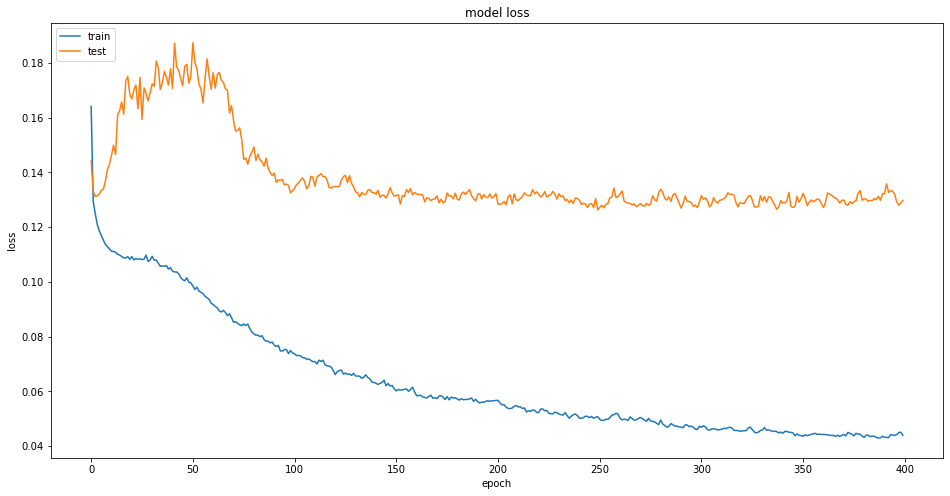

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('EFF_Model_TrainingandValidation Loss.png')
#print(get_flops(model))

In [7]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)

In [8]:
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('Alpha0.5_EFFmodel_testPredict.txt', tePredict)
 
print(tePredict.shape)
print(testY.shape)

(109896,)
(109896,)


In [9]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict), 'MAPE == ', mean_absolute_percentage_error(testY, tePredict))

Error Test Score > RMSE ==  0.11828662378280974  MAE ==  0.06393178588595208 MAPE ==  inf


C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
import shap
shap.initjs()
background = trX[np.random.choice(trX.shape[0], 300, replace=False)]
print(background.shape)
explainer = shap.DeepExplainer(model, background)
test_sample = trX[-100:]
shap_values = explainer.shap_values(background)

(300, 24, 9)



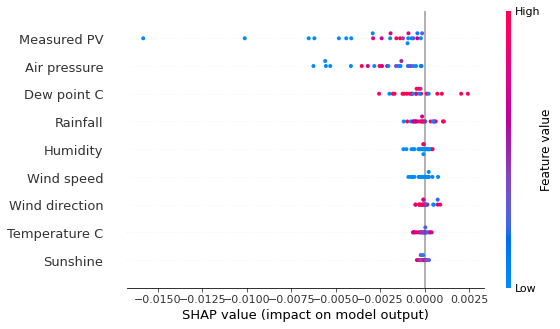

In [11]:
shap.summary_plot(shap_values[0][0], background[0], feature_names=index)
#shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=index)

In [12]:
shap_np = np.array(shap_values[0])
print(shap_np.shape)

(300, 24, 9)


In [13]:
shap_np = shap_np.reshape(-1,num_features)
print("=========================================================================")
print(shap_np)
np.savetxt('SHAP_VALUES_0.5alphaEFFmodel.txt', shap_np)

[[-6.52128038e-03 -5.72019255e-04  5.16588702e-04 ... -5.58998112e-03
   9.70444069e-04 -7.44237642e-05]
 [-6.20176204e-03 -5.07192258e-04 -4.77494628e-04 ... -5.30799016e-03
   2.06021458e-03 -1.51591709e-04]
 [-4.82216969e-03 -6.57002938e-04 -6.10055119e-04 ... -6.25409831e-03
   2.43549382e-03 -2.46351713e-04]
 ...
 [-1.34521263e-03  7.73486303e-04 -1.40440118e-04 ...  2.13287151e-03
   4.86274460e-03 -1.55874256e-04]
 [ 6.90029268e-02  1.77504019e-03  9.49030614e-04 ...  4.02443203e-03
   9.22705477e-03  1.07022125e-03]
 [ 1.22478159e-01  9.52977020e-05  9.23385315e-04 ...  6.40111702e-03
   1.52800010e-02  2.91175385e-03]]


In [34]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21453, 12)
(21453, 12)


In [62]:
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [63]:
norm_df2 = norm_df.iloc[:21453,[0, 1, 4, 5, 6, 8, 9, 11, 12]]
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825


In [64]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9,Prediction10,Prediction11,Prediction12
0,0.004003,0.003343,0.006389,0.002587,-0.001756,-0.003282,-0.003833,-0.007294,0.018117,0.159502,0.434105,0.691079
1,-0.001480,-0.000044,0.002054,0.004332,0.005227,-0.005855,-0.011068,0.062938,0.245468,0.474909,0.663903,0.752621
2,-0.003892,-0.000854,0.003852,0.000101,-0.007664,0.002004,0.065506,0.230060,0.455570,0.626088,0.681921,0.647010
3,-0.010575,0.001645,0.001491,-0.015711,-0.021329,0.048473,0.208327,0.428513,0.613993,0.690788,0.669706,0.580286
4,-0.005197,0.001523,-0.004513,-0.009591,0.048596,0.211398,0.417488,0.590387,0.686123,0.671317,0.564769,0.401486


In [65]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1,Error2,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.004003,0.003343,0.006389,0.002587,-0.001756,-0.003282,-0.003833,-0.007294,-0.009790,0.002138,-0.067446,0.098831
1,-0.001480,-0.000044,0.002054,0.004332,0.005227,-0.005855,-0.011068,0.035031,0.088103,-0.026642,0.071655,0.079753
2,-0.003892,-0.000854,0.003852,0.000101,-0.007664,0.002004,0.037599,0.072695,-0.045981,0.033840,0.009052,0.058638
3,-0.010575,0.001645,0.001491,-0.015711,-0.021329,0.020566,0.050962,-0.073037,0.021745,0.017920,0.081334,0.067108
4,-0.005197,0.001523,-0.004513,-0.009591,0.020689,0.054033,-0.084063,-0.001861,0.013255,0.082944,0.051590,0.037145


In [66]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C,Prediction1,...,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834,0.004003,...,0.006389,0.002587,-0.001756,-0.003282,-0.003833,-0.007294,-0.009790,0.002138,-0.067446,0.098831
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479,-0.001480,...,0.002054,0.004332,0.005227,-0.005855,-0.011068,0.035031,0.088103,-0.026642,0.071655,0.079753
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152,-0.003892,...,0.003852,0.000101,-0.007664,0.002004,0.037599,0.072695,-0.045981,0.033840,0.009052,0.058638
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989,-0.010575,...,0.001491,-0.015711,-0.021329,0.020566,0.050962,-0.073037,0.021745,0.017920,0.081334,0.067108
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825,-0.005197,...,-0.004513,-0.009591,0.020689,0.054033,-0.084063,-0.001861,0.013255,0.082944,0.051590,0.037145


Saving heatmap


<Figure size 432x288 with 0 Axes>

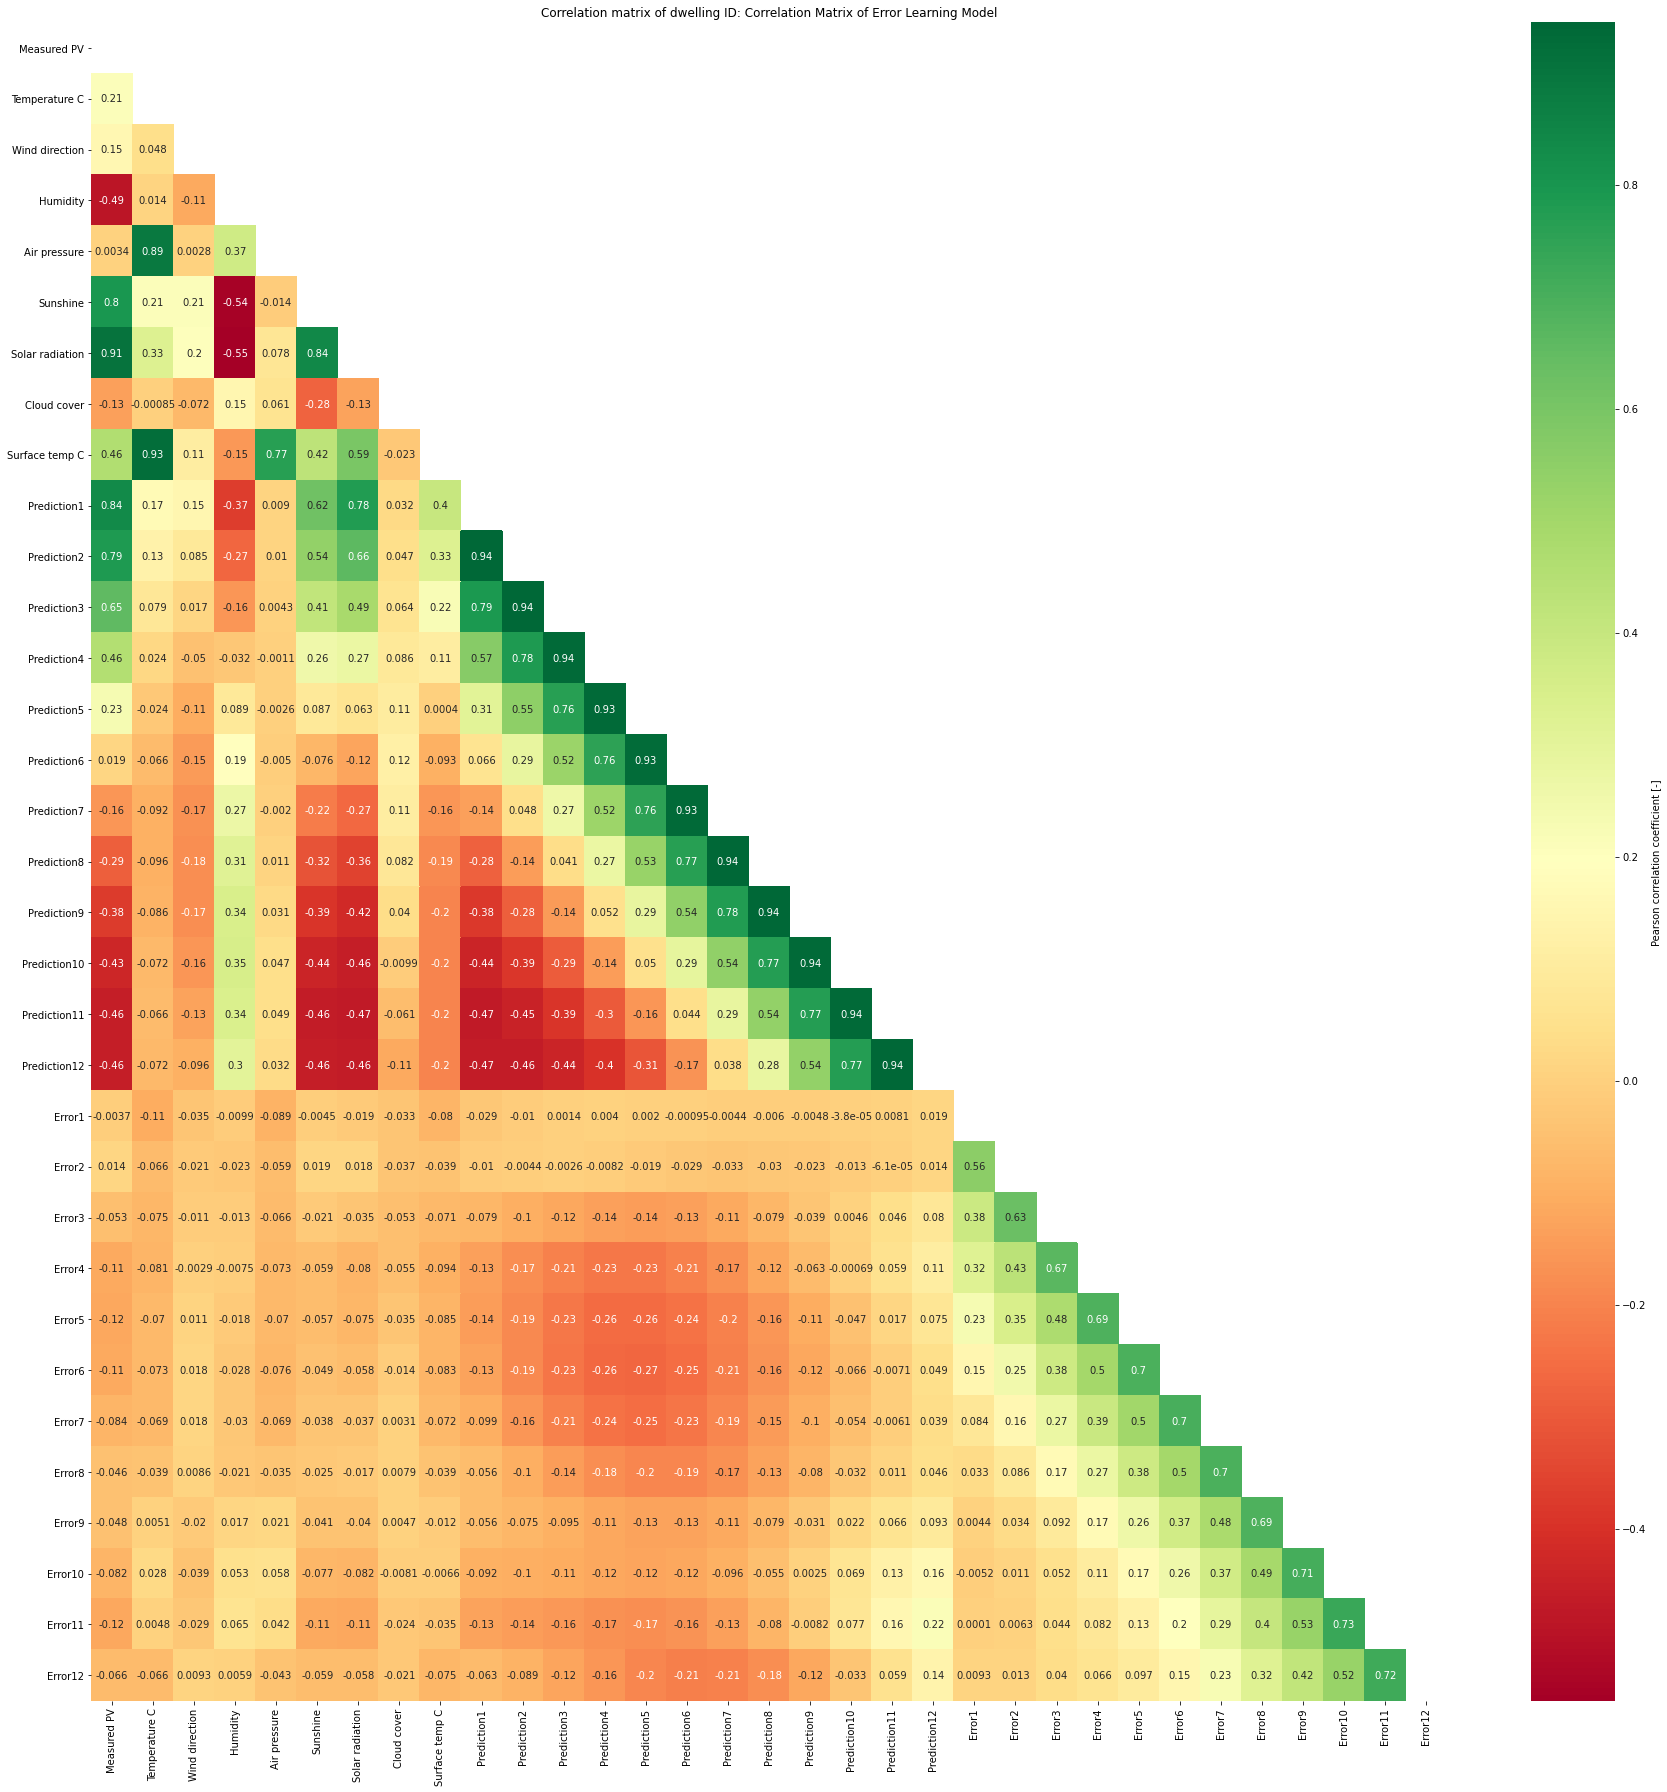

In [74]:
import seaborn as sns
from keijzer import *

fig = create_corr_matrix(norm_df2, 'Correlation Matrix of Error Learning Model', True, size=(25,25))


In [40]:
norm_df2 = np.array(norm_df2)
timesteps = 24
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21427, 24, 33)
(21427, 1, 33)


In [41]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, 21:]
vaYe = Ye[19000:, :, 21:]
trYe = trYe.reshape(-1,12)
vaYe = vaYe.reshape(-1,12)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 24, 33)
(19000, 12)
(2427, 24, 33)


In [42]:
with tf.device('/gpu:0'):
    alpha=0.5
    beta = math.sqrt(2/alpha)
    num_features = 33
    hfilters = 256
    hkernel_size1 = 16
    hkernel_size2 = 32
    visible1e = Input(shape=(24, num_features))
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1e)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res10 = Add()([d1, res09])   # (100, 25) (100, 25)
    oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
    oute = Dropout(0.2)(oute)   
    oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 1 is 1x1 conv, same is normal conv.  
    oute = Dropout(0.2)(oute)  
    oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1
    oute = Dense(12)(oute) 
    modele = Model(inputs=[visible1e], outputs=[oute])
    
    print(modele.summary())
    
    modele.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()

    histe = modele.fit(trXe, trYe, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaXe, vaYe), callbacks=[history, early_stopping])  # , checkpoint

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 24, 33)]     0                                            
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 24, 128)      135296      input_6[0][0]                    
__________________________________________________________________________________________________
activation_200 (Activation)     (None, 24, 128)      0           conv1d_110[0][0]                 
__________________________________________________________________________________________________
activation_201 (Activation)     (None, 24, 128)      0           conv1d_110[0][0]                 
____________________________________________________________________________________________

In [50]:
norm_df2 = norm_df.iloc[21453:,[0, 1, 4, 5, 6, 8, 9, 11, 12]]
pr_df = pd.DataFrame(tePredict.reshape(-1,12), columns=Prindex)
teY = testY.reshape(-1,12)
e_te = testPredict-teY
er_df = pd.DataFrame(e_te, columns=Erindex)

norm_df2 = np.array(norm_df2)[24:-13,:]

pr_df = np.array(pr_df)
er_df = np.array(er_df)

print(norm_df2.shape, pr_df.shape, er_df.shape)
norm_df2 = np.concatenate((norm_df2, pr_df, er_df),axis=1)
print(norm_df2.shape)

(9158, 9) (9158, 12) (9158, 12)
(9158, 33)


In [52]:
eteX, eteY = create_dataset(norm_df2, timesteps, output_timesteps)
eteY = eteY[:,:,21:].reshape(-1,12)
print(eteX.shape)
print(eteY.shape)

(9132, 24, 33)
(9132, 12)


In [53]:
etePredict = modele.predict(eteX, batch_size=batch_size)
print(etePredict.shape)
print(etePredict)

(9132, 12)
[[ 0.00535631  0.00359953  0.00373974 ... -0.01605945 -0.02228646
   0.00130197]
 [ 0.00486732  0.00298692  0.00375061 ... -0.01332036  0.01908272
   0.02281731]
 [ 0.00511505  0.0014835   0.00345468 ...  0.06854171 -0.04298566
   0.02977862]
 ...
 [ 0.026795   -0.00212623 -0.04695423 ...  0.03623384 -0.04679653
  -0.0006005 ]
 [ 0.0378277   0.00347551 -0.06947905 ... -0.00593246 -0.03856108
   0.01759379]
 [ 0.04861487  0.0332746  -0.05011172 ... -0.0571702  -0.0318048
  -0.01283238]]


In [54]:
testPredict = tePredict.reshape(-1,12)
addtestPredict = -etePredict + testPredict[24:-2,:]
print(addtestPredict.shape)

(9132, 12)


In [55]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[24:-2,:]-testPredict[24:-2,:]))), ' MAE == ', mean_absolute_error(teY[24:-2,:], testPredict[24:-2,:]), 'MAPE == ', mean_absolute_percentage_error(teY[24:-2,:], testPredict[24:-2,:]))
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[24:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[24:-2,:], addtestPredict), 'MAPE == ', mean_absolute_percentage_error(teY[24:-2,:], addtestPredict))

Error Test Score > RMSE ==  0.11832337817831877  MAE ==  0.06391501341696706 MAPE ==  inf
Error Test Score > RMSE ==  0.06398150855104896  MAE ==  0.03703419182807849 MAPE ==  inf


divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [56]:
shap.initjs()
background = trXe[np.random.choice(trXe.shape[0], 300, replace=False)]
print(background.shape)
explainer = shap.DeepExplainer(modele, background)
test_sample = trXe[-100:]
shap_values = explainer.shap_values(background)

(300, 24, 33)


In [57]:
eindex = np.hstack([index, Prindex, Erindex])
print(eindex)

['Measured PV' 'Temperature C' 'Rainfall' 'Wind speed' 'Wind direction'
 'Humidity' 'Air pressure' 'Dew point C' 'Sunshine' 'Solar radiation'
 'Snowfall' 'Cloud cover' 'Surface temp C' 'Prediction1' 'Prediction2'
 'Prediction3' 'Prediction4' 'Prediction5' 'Prediction6' 'Prediction7'
 'Prediction8' 'Prediction9' 'Prediction10' 'Prediction11' 'Prediction12'
 'Error1' 'Error2' 'Error3' 'Error4' 'Error5' 'Error6' 'Error7' 'Error8'
 'Error9' 'Error10' 'Error11' 'Error12']


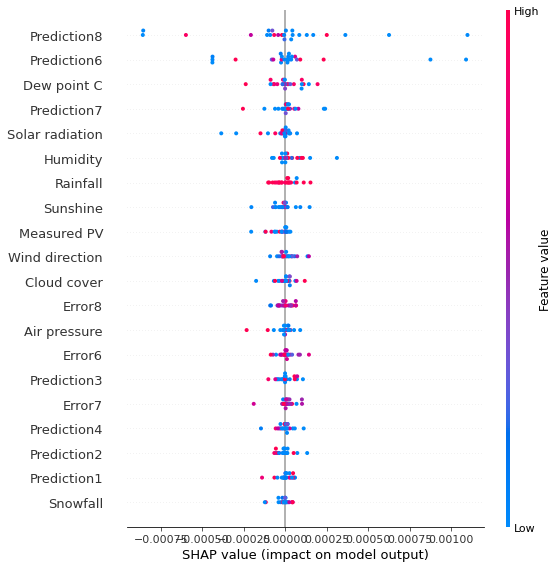

In [58]:
shap.summary_plot(shap_values[0][0], background[0], feature_names=eindex)
#shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=index)

In [59]:
shap_np = np.array(shap_values[0])
print(shap_np.shape)

(300, 24, 33)


In [61]:
shap_np = shap_np.reshape(-1,33)
print("=========================================================================")
print(shap_np)
np.savetxt('SHAP_VALUES_0.7alphaFSEFF_Errormodel.txt', shap_np)

[[-1.21084865e-04  1.73513426e-05  1.10260940e-04 ... -1.03197405e-06
   6.58595703e-06  3.07680510e-05]
 [-2.06476915e-04  5.66294896e-06  6.74863597e-05 ... -9.23283611e-06
   2.17148651e-05  1.00808599e-06]
 [ 2.20257186e-05 -9.08300683e-05  1.50949599e-04 ...  8.97848626e-06
  -1.39893759e-05 -8.66607315e-05]
 ...
 [ 3.45816431e-05 -3.68152287e-05 -1.15668817e-04 ... -5.78349451e-05
  -1.49584764e-04  3.85214573e-04]
 [-7.21071691e-06  9.60997927e-05 -7.78895013e-05 ... -1.26605011e-04
  -4.44059382e-04  2.34133532e-04]
 [ 8.48249136e-05  1.25968070e-04 -1.25805636e-04 ... -2.61728223e-05
  -9.13215273e-04 -3.59914585e-04]]
